Data Processing Notebook
===

Prepare data for the analysis. The raw data is downloaded from the FAIR Universe HiggsML challenge repository. Use the HiggsML package to download and process the dataset, followed by selections and saving to local cache.



In [43]:
import os, sys, importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import yaml
import uproot

from utils import plot_kinematic_features

import nsbi_common_utils
from nsbi_common_utils import configuration
from nsbi_common_utils import datasets


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

hep.style.use(hep.style.ATLAS)

Load Datasets
--

In [49]:
# Specify branches to load from the ROOT ntuples

input_features_noJets = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_had_pt', 'PRI_had_eta',
       'PRI_had_phi', 'PRI_met', 'PRI_met_phi', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltar_had_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_had', 'DER_met_phi_centrality']

input_features_1Jets = ['PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi',
       'PRI_jet_all_pt']

input_features_2Jets = ['PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet',
       'DER_lep_eta_centrality']

input_features_nJets = ['PRI_n_jets']

branches_to_load = input_features_noJets \
                    + input_features_1Jets \
                    + input_features_2Jets \
                    + input_features_nJets

In [50]:
importlib.reload(sys.modules['nsbi_common_utils.datasets'])
from nsbi_common_utils import datasets

# Pass the configuration file path and branches to load to the datasets module
Datasets = nsbi_common_utils.datasets.datasets(config_path = './config.yml',
                                                branches_to_load = branches_to_load)

In [51]:
# Load the datasets with branches_to_load, converting to Pandas DataFrame for processing
datasets_all = Datasets.load_datasets_from_config(load_systematics = True)

Preprocessing
--

In [52]:
input_features_by_jet = {
        1   :   input_features_1Jets, 
        2   :   input_features_2Jets
    }

median_feature = {}

for sample, sample_dataset in datasets_all["Nominal"].items(): 

    median_feature[sample] = {}

    for feature in input_features_1Jets:

        median_feature[sample][feature] = np.median(sample_dataset.loc[sample_dataset['PRI_n_jets'] >=1, feature])

    for feature in input_features_2Jets:
        
        median_feature[sample][feature] = np.median(sample_dataset.loc[sample_dataset['PRI_n_jets'] >=2, feature])
        

In [53]:
branches_to_add = []

for region, sample_datasets in datasets_all.items():

    for sample, sample_dataset in sample_datasets.items():   
        
        sample_dataset['njet_0'] = (sample_dataset['PRI_n_jets'] == 0).astype(int)
        sample_dataset['njet_1'] = (sample_dataset['PRI_n_jets'] == 1).astype(int)
        sample_dataset['njet_2'] = (sample_dataset['PRI_n_jets'] >= 2).astype(int)

        branches_to_add = branches_to_add + ['njet_0', 'njet_1', 'njet_2']

        for i, feat_list in input_features_by_jet.items():
            mask_i = (sample_dataset['PRI_n_jets'] >= i).astype(float)
            sample_dataset[f'jet{i}_mask'] = mask_i

            branches_to_add = branches_to_add + [f'jet{i}_mask']

            for feat in feat_list:
                sample_dataset[feat]    = sample_dataset[feat].where(sample_dataset['PRI_n_jets'] >= i, median_feature[sample][feat])

        for feat in branches_to_load.copy():

            kin = sample_dataset[feat].to_numpy()
            
            if (np.amin(kin) > 0.0) and (np.amax(kin)>100):
                log_feat = 'log_'+feat
                sample_dataset[log_feat] = np.log(kin+10.0)

                if log_feat not in branches_to_add:
                    branches_to_add         = branches_to_add + [log_feat]

        datasets_all[region][sample] = sample_dataset


In [54]:
Datasets.add_appended_branches(branches_to_add)

In [19]:
Datasets.save_datasets(datasets_all, 
                        save_systematics = True)

Visualize the data
-

Check for low-stats phase space and effect from systematics before moving to the density ratio training.

In [58]:
import sys, importlib
importlib.reload(sys.modules['utils'])
from utils import plot_kinematic_features

In [59]:
samples_list = list(datasets_all["Nominal"].keys())

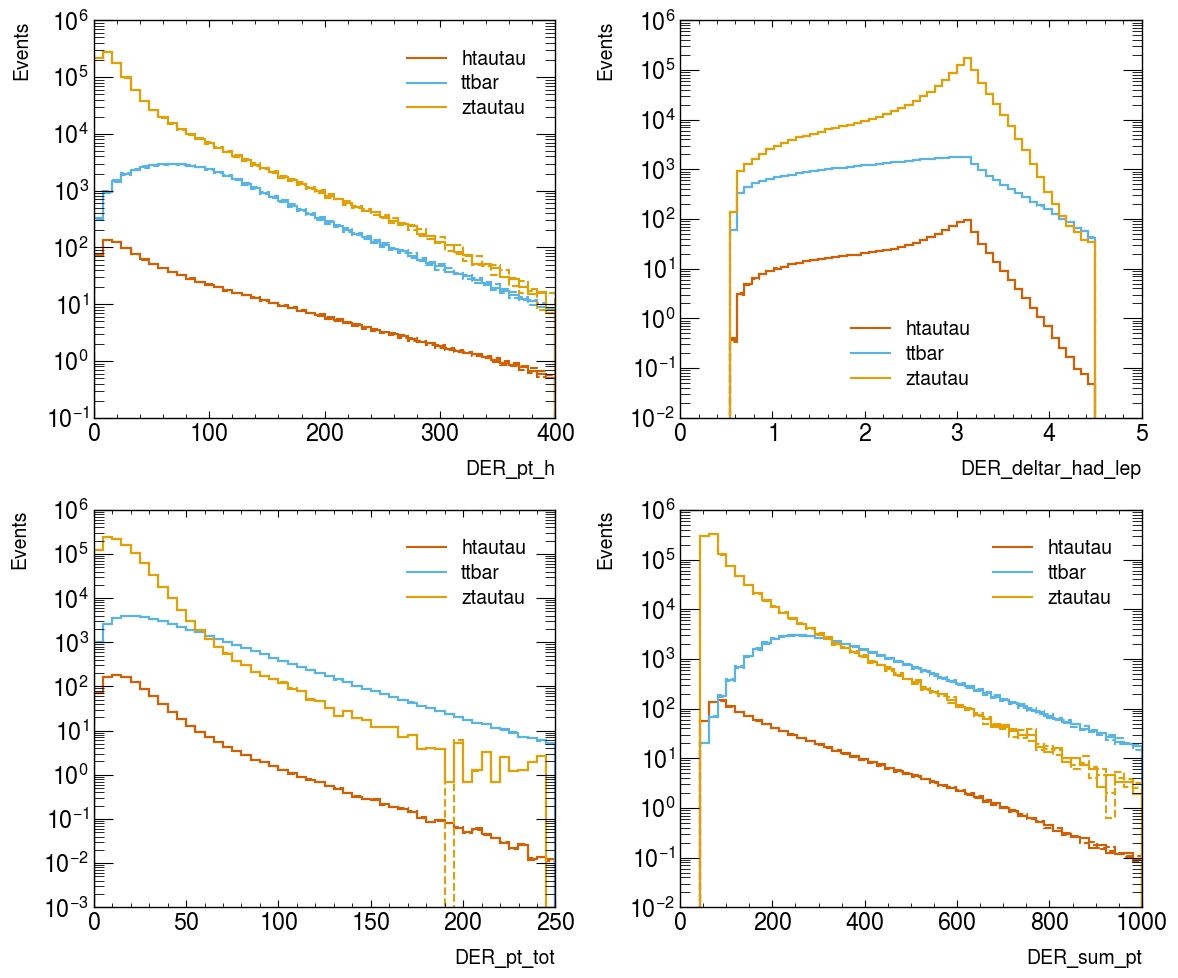

In [62]:
columns = ['DER_pt_h', 'DER_deltar_had_lep', 'DER_pt_tot', 'DER_sum_pt']
nbins = 50

xlabel_dict = {
    'PRI_lep_pt': 'lepton $p_T$ [GeV]', 
    'PRI_lep_eta': 'lepton $\\eta$ [GeV]', 
    'PRI_met': 'MET [GeV]', 
    'PRI_met_phi': 'MET $\\phi$',     
    'PRI_n_jets': '$n_{jets}$'      
}

variations_to_plot = ['Nominal', 'JES_Up', 'JES_Dn']

fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=datasets_all,
    xlabel_dict=xlabel_dict,
    samples_list=samples_list
)
plt.show()


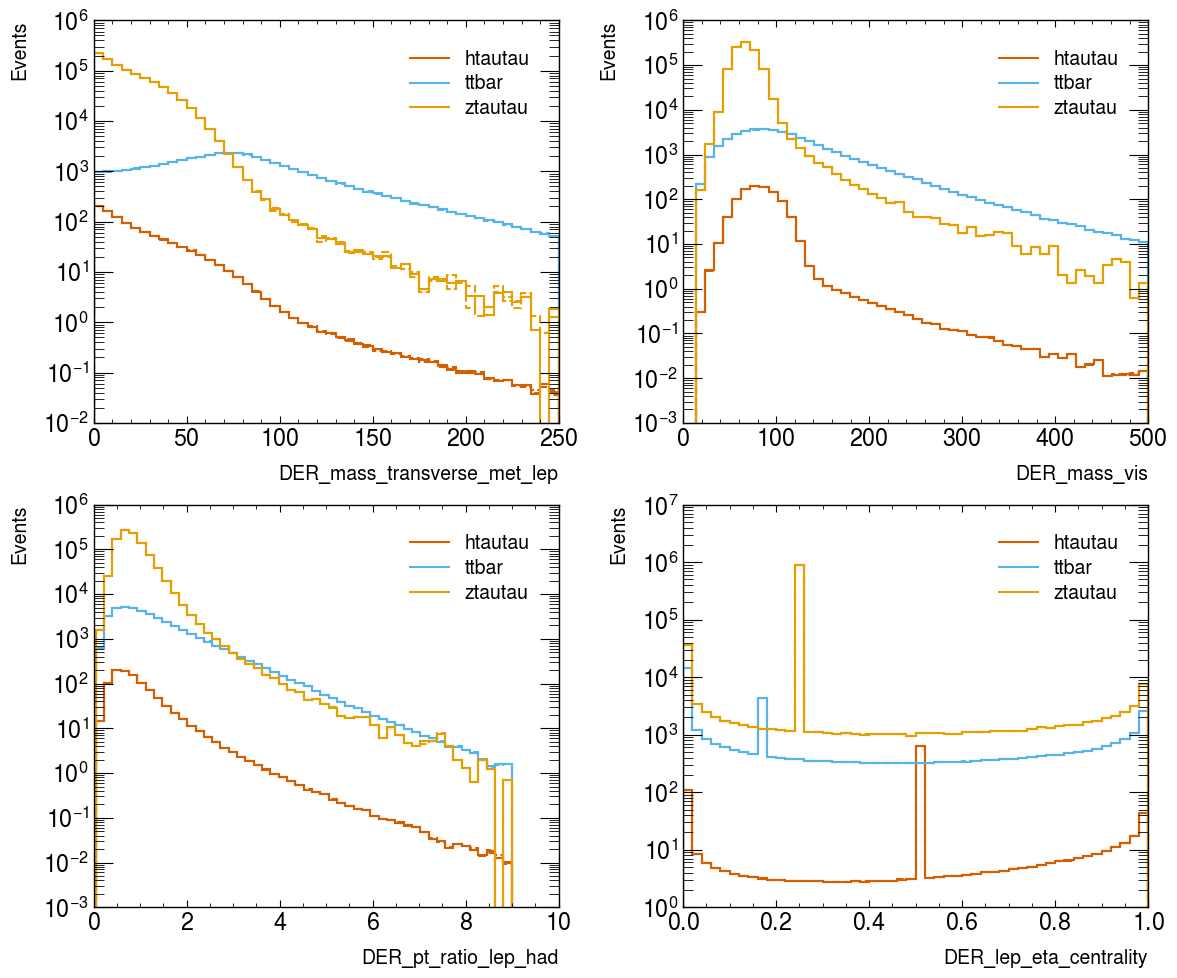

In [63]:
columns = ['DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_ratio_lep_had', 'DER_lep_eta_centrality']

nbins = 50

xlabel_dict = {
    'DER_mass_transverse_met_lep': 'DER_mass_transverse_met_lep', 
    'DER_mass_vis': 'DER_mass_vis', 
    'DER_pt_ratio_lep_had': 'DER_pt_ratio_lep_had', 
    'DER_lep_eta_centrality': 'DER_lep_eta_centrality',       
}

variations_to_plot = ['Nominal', 'JES_Up', 'JES_Dn']


fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=datasets_all,
    xlabel_dict=xlabel_dict,
    samples_list=samples_list
)
plt.show()



<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_3467848/2432422146.py:8: SyntaxWarning: invalid escape sequence '\e'
  'DER_prodeta_jet_jet': '$\eta_{j1}\eta_{j2}$',


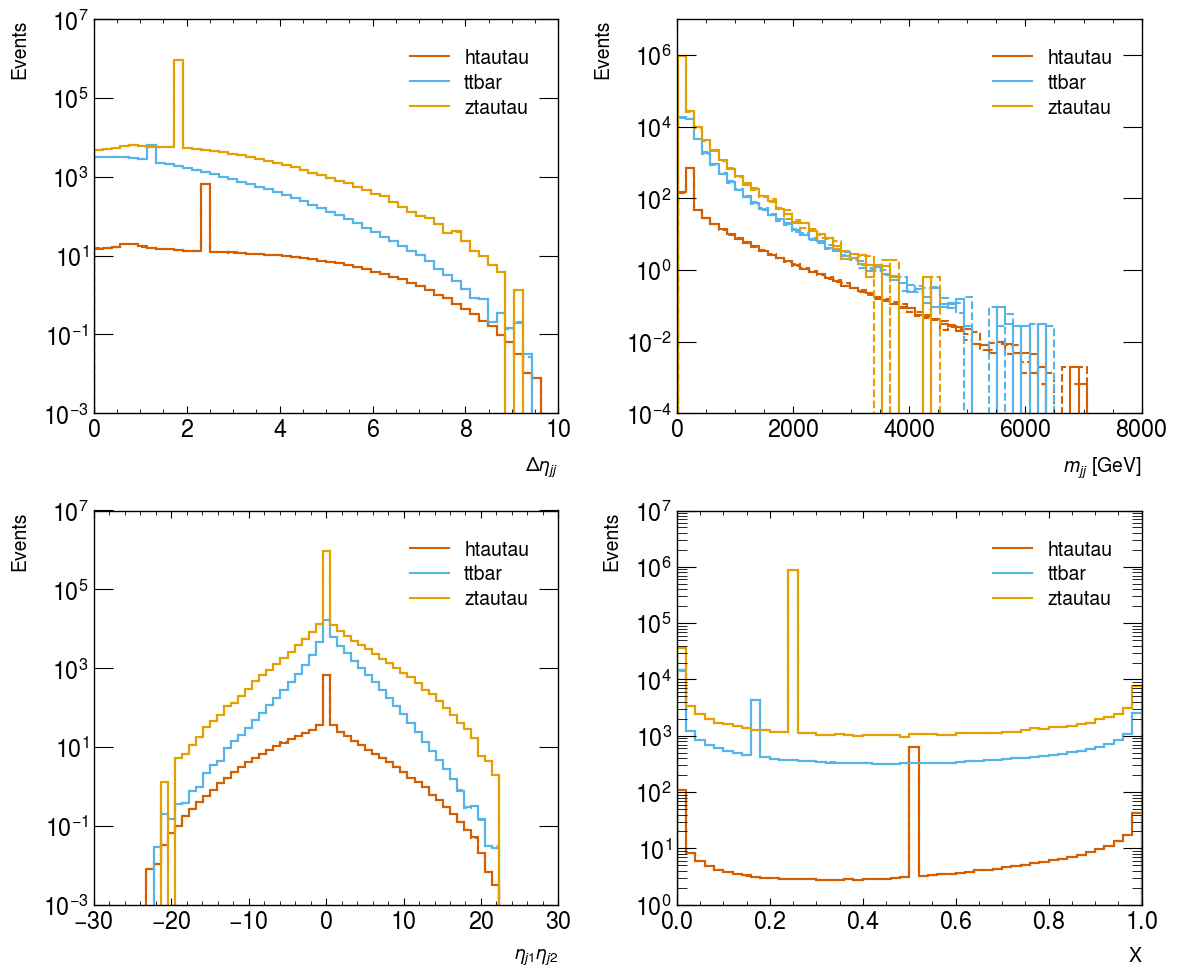

In [64]:
columns = ['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 
           'DER_prodeta_jet_jet', 'DER_lep_eta_centrality']
nbins = 50

xlabel_dict = {
    'DER_deltaeta_jet_jet': r'$\Delta \eta_{jj}$', 
    'DER_mass_jet_jet': '$m_{jj}$ [GeV]', 
    'DER_prodeta_jet_jet': '$\eta_{j1}\eta_{j2}$', 
    'DER_lep_eta_centrality': 'X',
}

variations_to_plot = ['Nominal', 'JES_Up', 'JES_Dn']


fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=datasets_all,
    xlabel_dict=xlabel_dict,
    samples_list=samples_list
)
plt.show()

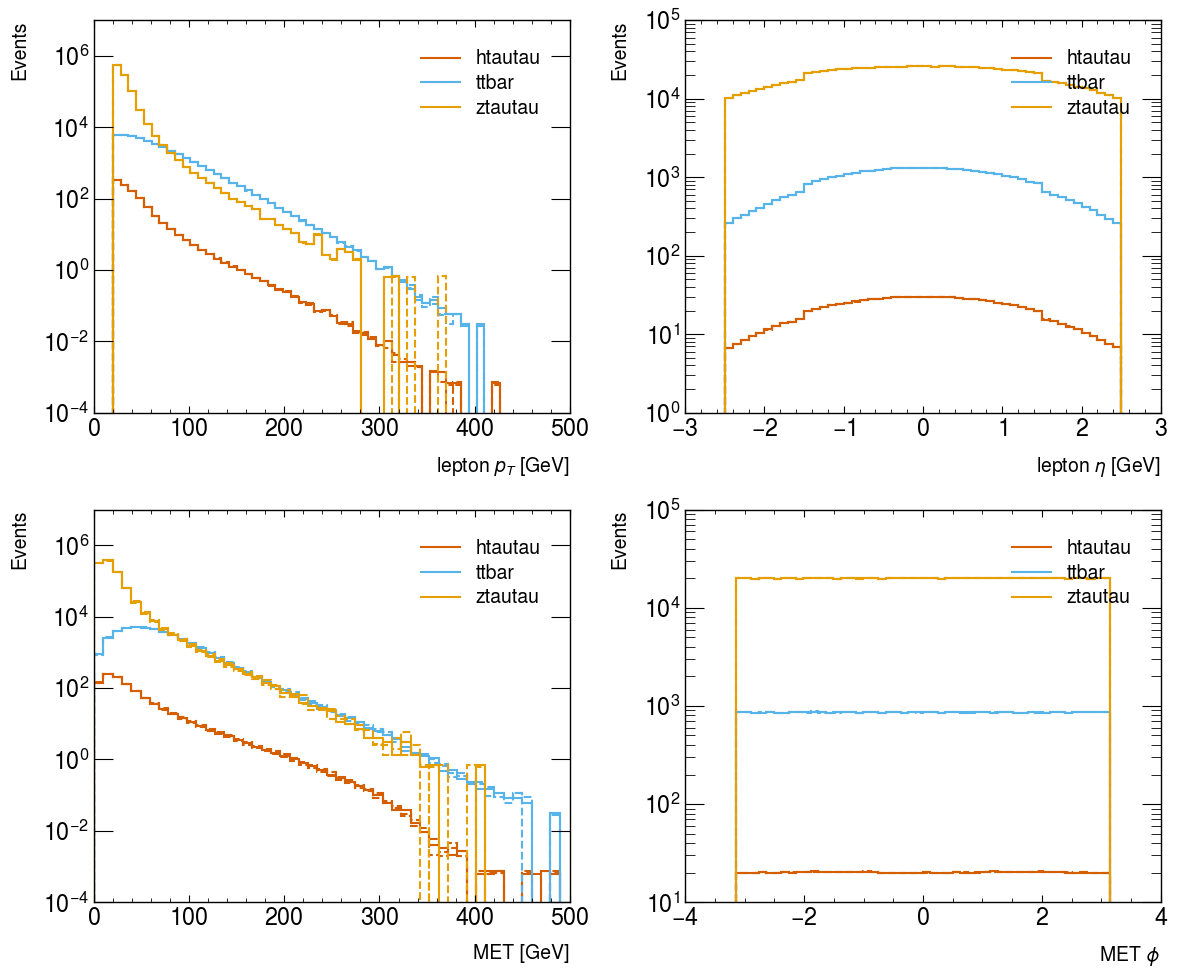

In [65]:
columns = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi']
nbins = 50

xlabel_dict = {
    'PRI_lep_pt': 'lepton $p_T$ [GeV]', 
    'PRI_lep_eta': 'lepton $\\eta$ [GeV]', 
    'PRI_met': 'MET [GeV]', 
    'PRI_met_phi': 'MET $\\phi$',     
    'PRI_n_jets': '$n_{jets}$'      
}

variations_to_plot = ['Nominal', 'JES_Up', 'JES_Dn']


fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=datasets_all,
    xlabel_dict=xlabel_dict,
    samples_list=samples_list
)
plt.show()


<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_3467848/3719328280.py:7: SyntaxWarning: invalid escape sequence '\e'
  'PRI_had_eta': 'hadron $\eta$ [GeV]',
/tmp/ipykernel_3467848/3719328280.py:8: SyntaxWarning: invalid escape sequence '\p'
  'PRI_had_phi': 'hadron $\phi$',


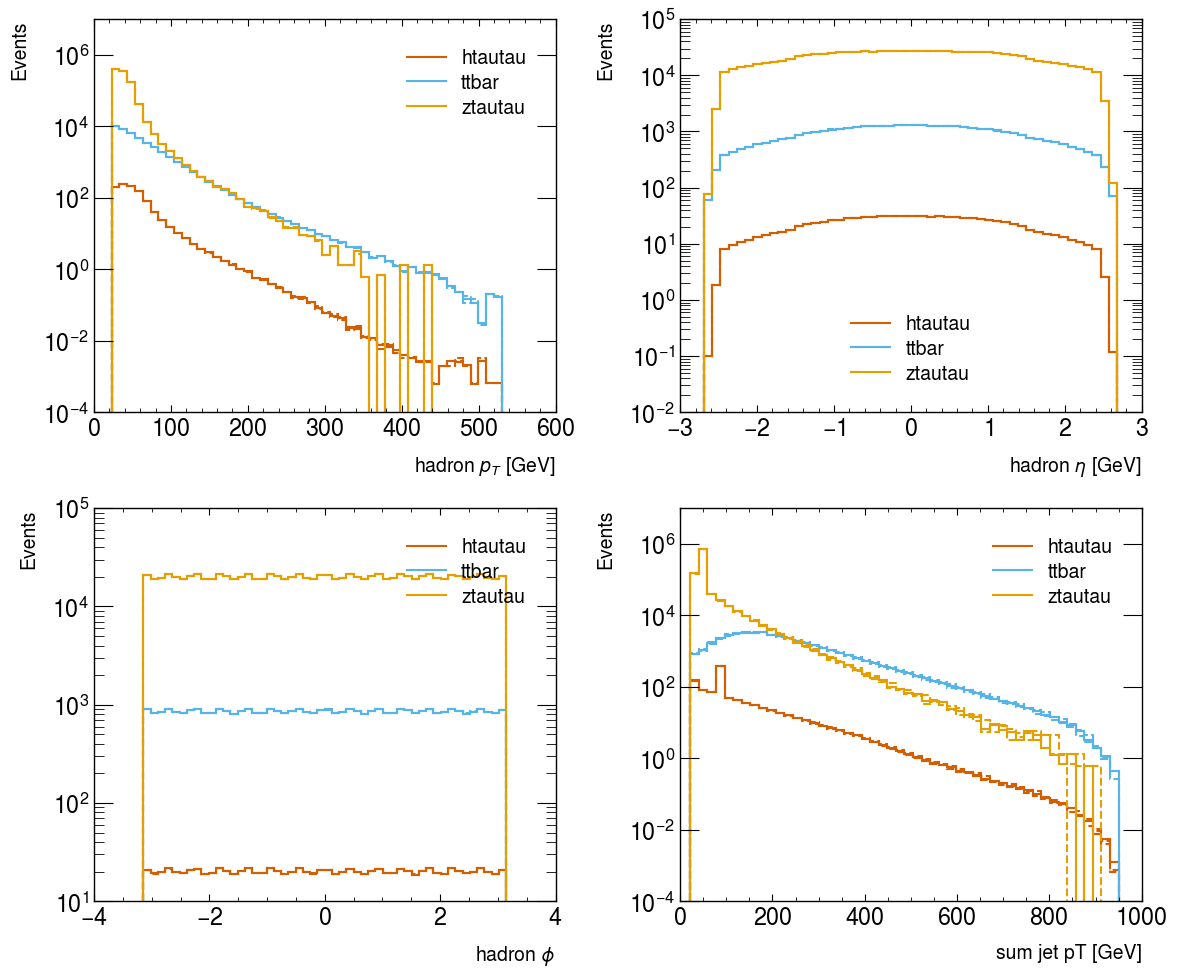

In [66]:
columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_all_pt']
# columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi']
nbins = 50

xlabel_dict = {
    'PRI_had_pt': 'hadron $p_T$ [GeV]', 
    'PRI_had_eta': 'hadron $\eta$ [GeV]', 
    'PRI_had_phi': 'hadron $\phi$', 
    'PRI_jet_all_pt': 'sum jet pT [GeV]',
}

variations_to_plot = ['Nominal', 'JES_Up', 'JES_Dn']


fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=datasets_all,
    xlabel_dict=xlabel_dict,
    samples_list=samples_list
)
plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_3467848/2362404005.py:8: SyntaxWarning: invalid escape sequence '\e'
  'PRI_jet_leading_eta': 'leading jet $\eta$ [GeV]',
/tmp/ipykernel_3467848/2362404005.py:9: SyntaxWarning: invalid escape sequence '\p'
  'PRI_jet_leading_phi': 'leading jet $\phi$',


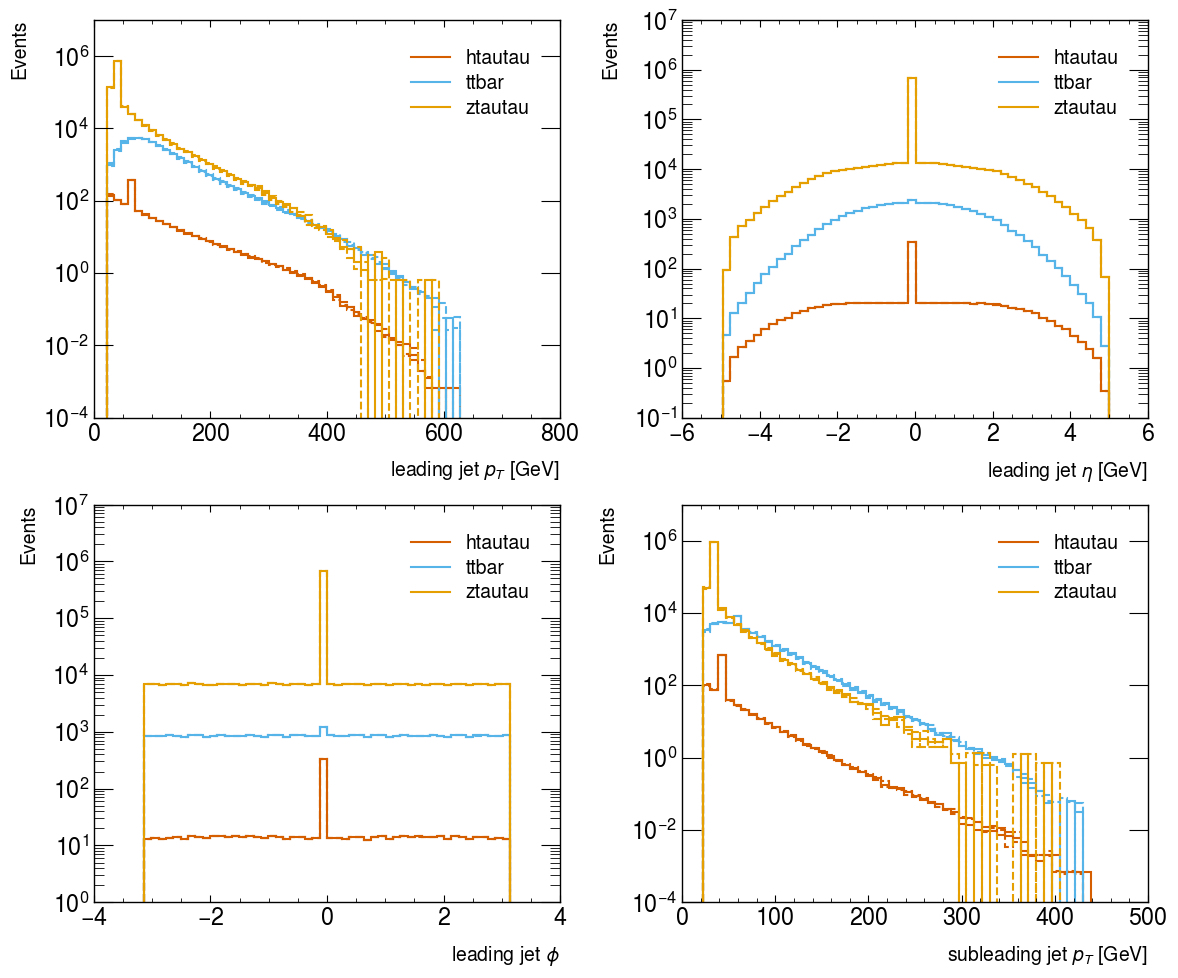

In [67]:
columns = ['PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt']

# columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi']
nbins = 50

xlabel_dict = {
    'PRI_jet_leading_pt': 'leading jet $p_T$ [GeV]', 
    'PRI_jet_leading_eta': 'leading jet $\eta$ [GeV]', 
    'PRI_jet_leading_phi': 'leading jet $\phi$', 
    'PRI_jet_subleading_pt': 'subleading jet $p_T$ [GeV]',
}

variations_to_plot = ['Nominal', 'JES_Up', 'JES_Dn']


fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=datasets_all,
    xlabel_dict=xlabel_dict,
    samples_list=samples_list
)
plt.show()